# Regressing DFT Electron Density Fields

In this notebook we use a cluster expansion-like approach to formulate the regression of DFT (density functional theory) gound state electron densities in form of a linear regression problem. This notebook makes use of the `pottytrainer` package and `RVMs` package. `pottytrainer` is used to parse CASTEP files and generate the design matrix. `RVMs` is used to apply relevance vector machines to the regression problem, but other regression methods as implemented in `sklearn` can be used just the same.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interpolate, stats
import pickle
import itertools, warnings, copy, time, sys
import pickle
from ase.spacegroup import crystal
import matplotlib.pylab as plt
from sklearn import linear_model, preprocessing
import sklearn
from ase.calculators.eam import EAM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, RidgeCV, ARDRegression

import atomtoolbox as atb
import RVMs

import pottytrainer
from pottytrainer import fitelectrondensity as fed
from pottytrainer import fitenergy as fe

from scipy.interpolate import InterpolatedUnivariateSpline as spline
from pottytrainer import parsers

import time

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## Parsing Data To Regress

In [5]:
# info loading from disk
dft_path = "E:/PetProjects/Empirical Potentials/castep/alloy_regression/Al-Ni_small/"

# info for bonds
r_cut = 6.
aniso = False
r_smooth_low = .5
selection=("atom",r_smooth_low,"r") # first tuple entry specifies selection type, following fix specifics, i.e.("random",10.) mean select 10% of all points uniformly at random 
seed = None
np.random.seed(seed=seed)

# parsing DFT files
print("\nparsing DFT files...")
gip = parsers.general.GeneralInputParser(verbose=False)
gip.parse_all(dft_path)
gip.sort()

print("done")

print("\nsetting up bonds...")
bonds = []
for g in gip:
    print("\nprocessing: {}".format(g.get_name()))
    _bonds = fed.misc.get_observations(g,ultra_num=None,num_neigh=None,
                                       r_cut=r_cut,aniso=aniso,verbose=False,
                                       selection=selection,seed=seed)
    bonds.extend(_bonds)

bonds, min_dens = atb.electron_density.rescale_and_shift_densities(bonds, rescale=True, offset=1e-6)
edens = np.array([b.t["density"] for b in bonds])
print("\nmin {:.2f} max {:.2f} mean {:.2f} std {:.2f}".format(edens.min(), edens.max(), np.mean(edens), np.std(edens)))
edens /= 2.*np.std(edens)
edens -= edens.min() - 1.
print("min {:.2f} max {:.2f} mean {:.2f} std {:.2f}".format(edens.min(), edens.max(), np.mean(edens), np.std(edens)))
for i,b in enumerate(bonds):
    bonds[i].t["density"] = edens[i]
print("done")


parsing DFT files...
done

setting up bonds...

processing: A1_a_7
Found all cells for r_cut 6.0 => r_search = 14.25 Ang, terminating after 7 iterations

processing: A1_a_8


E:\Programs\Anaconda3\envs\py35\lib\site-packages\pottytrainer\fitelectrondensity\misc.py:398: RuntimeWarning: invalid value encountered in true_divide
  r_vec /= np.reshape(r["all"],(-1,1))


Found all cells for r_cut 6.0 => r_search = 14.25 Ang, terminating after 7 iterations

processing: A1_a_9
Found all cells for r_cut 6.0 => r_search = 14.26 Ang, terminating after 7 iterations

processing: A2_a_7
Found all cells for r_cut 6.0 => r_search = 13.02 Ang, terminating after 6 iterations

processing: A2_a_8
Found all cells for r_cut 6.0 => r_search = 13.03 Ang, terminating after 6 iterations

processing: A2_a_9
Found all cells for r_cut 6.0 => r_search = 13.03 Ang, terminating after 6 iterations

processing: A3_a_7
Found all cells for r_cut 6.0 => r_search = 14.13 Ang, terminating after 6 iterations

processing: A3_a_8
Found all cells for r_cut 6.0 => r_search = 14.14 Ang, terminating after 6 iterations

processing: A3_a_9
Found all cells for r_cut 6.0 => r_search = 14.14 Ang, terminating after 6 iterations

processing: AlNi_ICSD_107713_a_7
Found all cells for r_cut 6.0 => r_search = 15.40 Ang, terminating after 5 iterations

processing: AlNi_ICSD_107713_a_8
Found all cells fo

## Creating Design Matrix

In [6]:
# info for basis set
k_iso=250 # parameter for iso basis size
type_iso="Fourier" # type of basis for iso
smooth = True # apply smoothing of basis functions towards r_smooth
r_smooth = r_cut
r_scale = r_cut
self_contribution = False # whether or not an atom itself is considered contribution to the valence elenctron density
f_smooth = .1 # fudge factor for smoothing
usefortran = False

# get basis
print("\nsetting up basis and mapper...")
basis, mapper = fed.rvm.get_basis([gip],k_iso=k_iso,type_iso=type_iso,
                                  smooth=smooth,r_smooth=r_smooth,f_smooth=f_smooth,
                                  verbose=False,self_contribution=self_contribution, r_scale=r_scale)
print("done")

# get design matrix
print("\nsetting up design matrix and target vector...")
Phi, t = fed.rvm.get_design_matrix(bonds,basis,mapper,verbose=False,return_t=True,seed=seed,usefortran=usefortran)
print("design matrix dimension = {} x {}".format(Phi.shape[0],Phi.shape[1]))
print("done")


setting up basis and mapper...
done

setting up design matrix and target vector...
Generating design matrix for 5246 samples...
mapping >> s Al, ix_s 0, ix_e 250
mapping >> s Ni, ix_s 250, ix_e 500
design matrix dimension = 5246 x 500
done


## Regression via RVMs

In [7]:
# RVM initiate hyper parameters
niter = 300
tol = 1e-3
fix_beta = False
n_steps_beta = 5 # integer specifying every nth step to update beta
sequential = False
niter_stochastic = 1 # number of iterations generating new Phis according to variable 'stochastic' if stochastic[0] != "all"

# initialize priors
N, M = Phi.shape
## manually fixed
# alphas_init = np.ones(M)
# alphas_init[1:] = np.inf # default
# beta_init = 1./np.var(t) # default
## randomly drawn (useful for repetitions to check for regression convergence behavior)
beta_init = RVMs.linear_model.distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
alphas_init = RVMs.linear_model.distribution_wrapper(stats.halfnorm(scale=1),single=False)

print("regressing...")
## old version
# logbook = fed.rvm.iterate(Phi,t,niter=niter,verbose=False,alpha_init=alpha_init,beta_init=beta_init,tol=tol,
#                           fix_beta=fix_beta,sequential=sequential,n_steps_beta=n_steps_beta,seed=seed)
## new version
model = RVMs.linear_model.RelevanceVectorMachine(n_iter=niter, init_alphas=alphas_init,
                                                init_beta=beta_init, compute_score=True,
                                                do_logbook=True, fit_intercept=False,
                                                verbose=False, tol=tol, update_pct=.75)
model.fit(Phi,t.ravel())
logbook = model.get_logbook()
print("done")

regressing...
done


## Storing Obtained Models and Regression Data

Selected iteration 35 for output:
L = -41232924.7671361, mse = 6.509002725068645e-06, tse = 0.03414622829571011


<IPython.core.display.Javascript object>


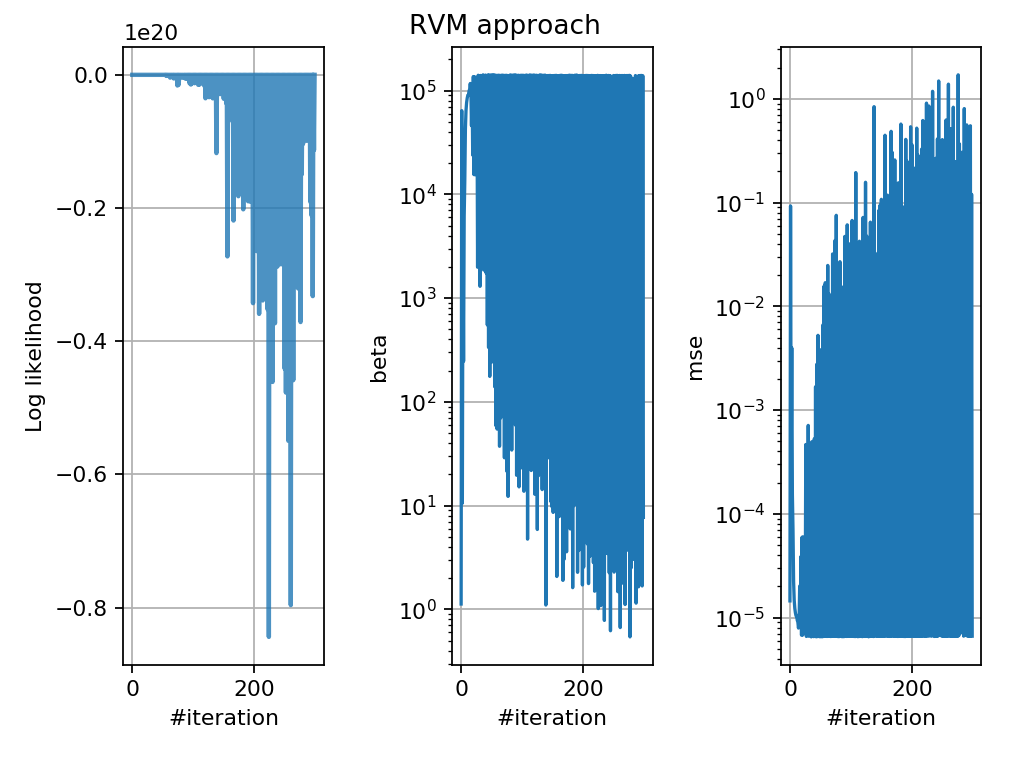

Calculating isotropic rhos: N_steps = 10000, r_smooth = 6.0, incrementing by 0.0006 up to 5.9994...


<IPython.core.display.Javascript object>


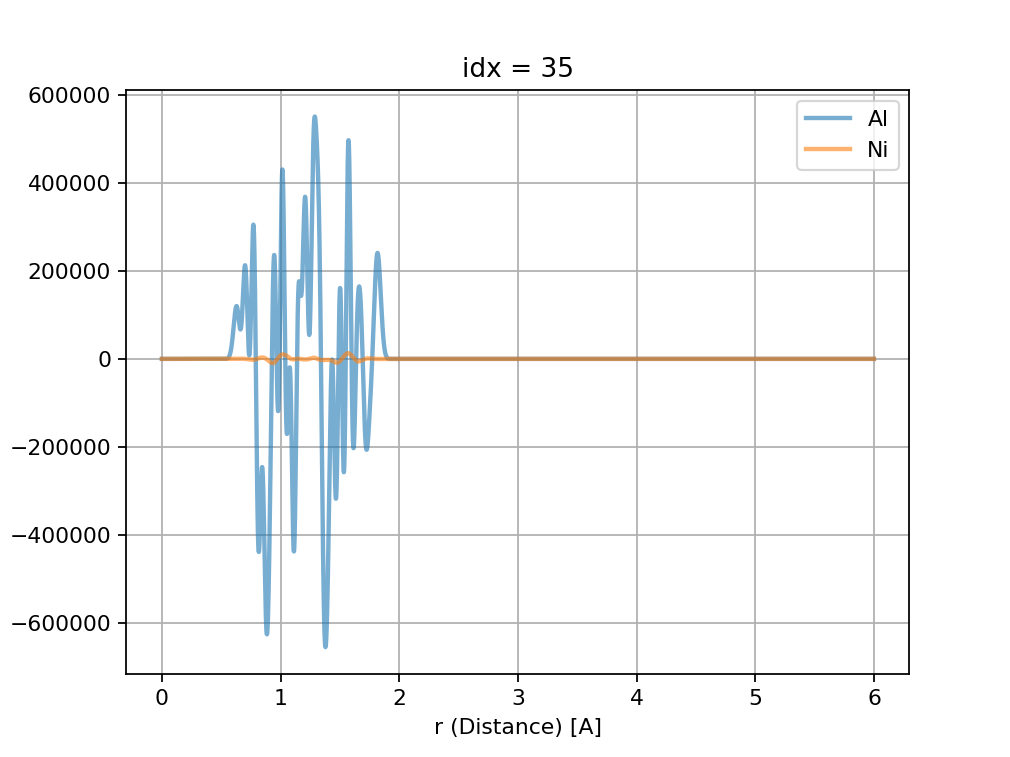

Saving the regression data to Al-Ni_small.rhos...


In [8]:
# save_path_rhos = "Al.rhos"
# save_path_rhos = "Al-Ni-Nb_small.rhos"
save_path_rhos = "Al-Ni_small.rhos"
#save_path_rhos = "Al-Nb.rhos"
# save_path_rhos = "Al-Nb-Ni.rhos"

# select weights according to some criterion
idx = np.nanargmin(logbook["mse"])
print("Selected iteration {} for output:\nL = {}, mse = {}, tse = {}".format(idx,logbook["L"][idx],logbook["mse"][idx],logbook["tse"][idx]))
weights = logbook["weights_full"][idx]
    
atb.show_rvm_performance(niter,logbook,log=True)

# plotting rho(r)
Nsteps_iso = 10000 #number of steps to to plot rho(r) from r = 0 to r = r_smooth
r, rhos = fed.predict.predict_rho_iso(mapper,weights,basis,r_smooth,Nsteps_iso)

fed.misc.show_rho_iso(r,rhos,title="idx = {}".format(idx)) # rho(r)

# saving final rhos to disk 
fed.misc.save_regressed_rho(r,rhos,save_path_rhos,lb=0,ub=r_smooth,dft_path=dft_path,logbook=logbook,i=idx,
                            niter=niter,tol=tol,fix_beta=fix_beta,sequential=sequential,
                            k_iso=k_iso,type_iso=type_iso,ultra_num=None,selection=selection,
                            num_neigh=None,r_cut=r_cut,aniso=aniso,smooth=smooth,r_smooth=r_smooth,
                            f_smooth=f_smooth,weights=weights)

## Comparing Predicted and DFT Densities

min 0.99 max 3.30 mean 1.41 std 0.50
min -0.02 max 0.02 mean -0.00 std 0.00


<IPython.core.display.Javascript object>


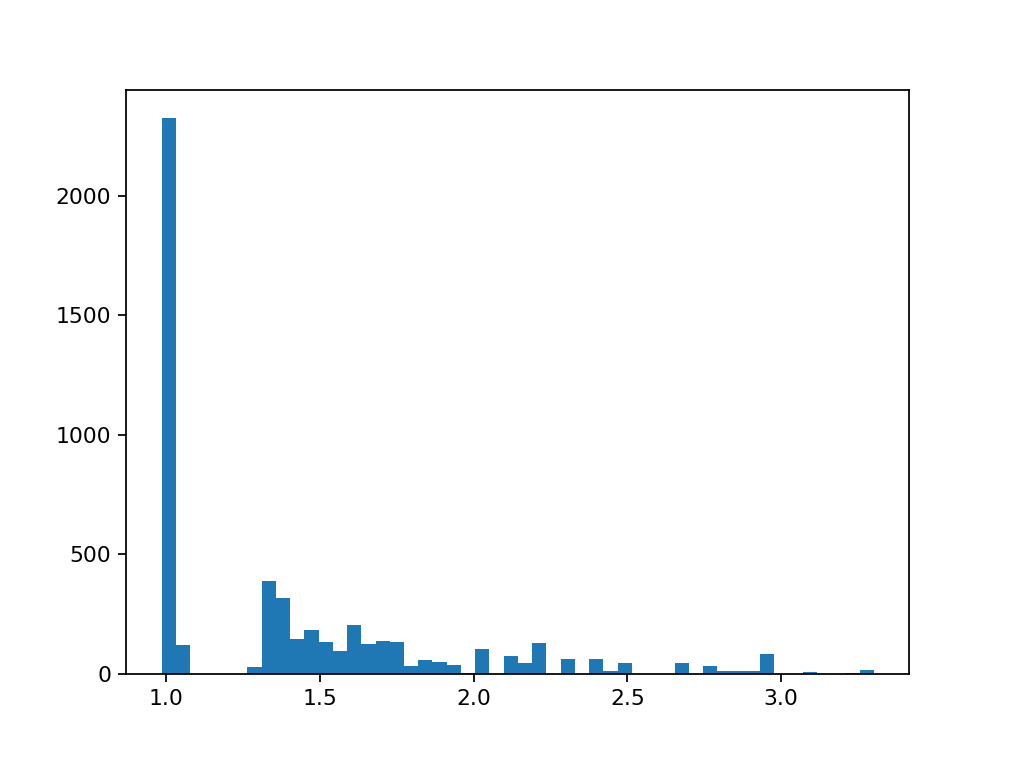

In [9]:
_edens_pred = np.dot(Phi,weights)
print("min {:.2f} max {:.2f} mean {:.2f} std {:.2f}".format(_edens_pred.min(),
                                                            _edens_pred.max(),
                                                            np.mean(_edens_pred),
                                                            np.std(_edens_pred)))
delta = _edens_pred.ravel() - t.ravel()
print("min {:.2f} max {:.2f} mean {:.2f} std {:.2f}".format(delta.min(),
                                                            delta.max(),
                                                            np.mean(delta),
                                                            np.std(delta)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(_edens_pred, bins=50)
plt.show()